# **Brain MRI Classification on WGAN GP synthetic data**

In [2]:
from zipfile import ZipFile as zipfile
file_name = 'wgan_gp.zip'

with zipfile(file_name, 'r') as zip_file:
  zip_file.extractall()

In [13]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import numpy as np
from sklearn import metrics

# ImageFolder class looks for images within folders (there should be a folder for each class)
data_real = os.path.abspath(os.getcwd()) + "/wgan_gp/real"
data_fake = os.path.abspath(os.getcwd()) + "/wgan_gp/fake"

img_size = 64

data_real = ImageFolder(data_real,transform = transforms.Compose([ transforms.Resize((img_size,img_size)),transforms.ToTensor()]))

data_fake = ImageFolder(data_fake, transform = transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()]))

In [14]:
samples_num = len(data_real)
test_num = int(samples_num * 0.3) 
train_num = samples_num - test_num 

train_data, test_data = random_split(data_real, [train_num, test_num])

validation_num = int(test_num * 0.5) 
test_num = test_num - validation_num

validation_data, test_data = random_split(test_data, [validation_num, test_num])

len(train_data), len(validation_data), len(test_data)

(517, 110, 111)

In [15]:
batch_size = 256
num_workers = 2

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
validation_data = DataLoader(validation_data, batch_size*2, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

In [4]:
class ClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, y = batch 
        predictions = self(images)
        loss = torch.nn.functional.cross_entropy(predictions, y)
        return loss
    
    def validation_step(self, batch):
        images, y = batch 
        predictions = self(images)

        loss = torch.nn.functional.cross_entropy(predictions, y)
        predictions = np.argmax(predictions, axis=-1)
        acc = metrics.accuracy_score(predictions, y)
        f1 = metrics.f1_score(predictions, y)
        
        return {'test_loss': loss.detach(), 'test_accuracy': torch.tensor(acc), 'f1': f1, 'predictions': predictions, 'y': y}

In [5]:
class ClassificationModel(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(32768, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )
    
    def forward(self, x):
        return self.network(x)

In [6]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    batch_losses = [x['test_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accuracies = [x['test_accuracy'] for x in outputs]
    epoch_accuracy = torch.stack(batch_accuracies).mean()
    f1 = [x['f1'] for x in outputs][0]
    predictions = [x['predictions'] for x in outputs][0]
    y = [x['y'] for x in outputs][0]
    
    return {'test_loss': epoch_loss.item(), 'test_accuracy': epoch_accuracy.item(),
            'f1': f1, 'predictions': predictions, 'y': y}
  
def fit(epochs, lr, model, train_set, test_set, opt_func = torch.optim.SGD):
    
    losses = []
    optimizer = opt_func(model.parameters(),lr)

    for epoch in range(epochs):
        
        model.train()
        train_losses = []

        for batch in train_set:

            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, test_set)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        losses.append(result)
 
        print("Epoch: {}, train loss: {:.5f}, test loss: {:.5f}, test accuracy: {:.5f}, f1 score: {:.5f}".format(
            epoch + 1, result['train_loss'], result['test_loss'], result['test_accuracy'], result['f1']))

    return losses

In [7]:
def plot_losses_per_epoch(losses):
    train_losses = [x.get('train_loss') for x in losses]
    val_losses = [x['test_loss'] for x in losses]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xticks(np.arange(len(train_losses)), np.arange(1, len(train_losses)+1))
    plt.xlabel('Epoch')
    plt.ylabel('L')
    plt.legend(['Training', 'Test'])

def plot_confusion_matrix(losses):
  # Plot the confusion matrix of the computed predictions for the highest number of epochs 
  predictions = losses[-1]['predictions'].numpy() 
  y = losses[-1]['y'].numpy() 
  cm = metrics.confusion_matrix(y, predictions)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
  cm_display.plot()
  plt.show()

Epoch: 1, train loss: 0.65281, test loss: 0.80034, test accuracy: 0.50909, f1 score: 0.00000
Epoch: 2, train loss: 0.66354, test loss: 0.62097, test accuracy: 0.53636, f1 score: 0.10526
Epoch: 3, train loss: 0.56115, test loss: 0.51842, test accuracy: 0.71818, f1 score: 0.61728
Epoch: 4, train loss: 0.40012, test loss: 0.83661, test accuracy: 0.71818, f1 score: 0.60759
Epoch: 5, train loss: 0.41416, test loss: 0.40013, test accuracy: 0.83636, f1 score: 0.84746
Epoch: 6, train loss: 0.19791, test loss: 0.55235, test accuracy: 0.81818, f1 score: 0.79592
Epoch: 7, train loss: 0.26915, test loss: 0.59026, test accuracy: 0.80000, f1 score: 0.82540
Epoch: 8, train loss: 0.37205, test loss: 0.59501, test accuracy: 0.83636, f1 score: 0.81250
Epoch: 9, train loss: 0.47859, test loss: 0.39955, test accuracy: 0.82727, f1 score: 0.81905
Epoch: 10, train loss: 0.24767, test loss: 0.60204, test accuracy: 0.76364, f1 score: 0.80597
Epoch: 11, train loss: 0.39728, test loss: 0.37523, test accuracy: 0.

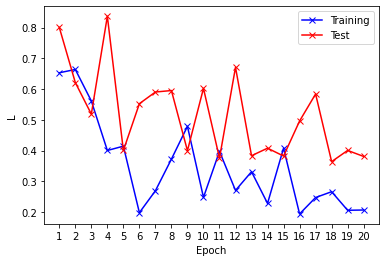

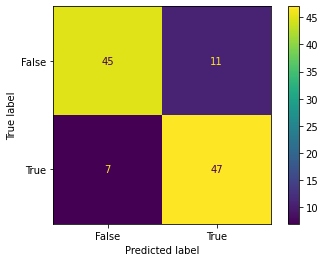

In [8]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, validation_data, opt_func)

plot_losses_per_epoch(losses)
plot_confusion_matrix(losses)

Since epochs 14, 15 produced the highest accuracy on the validation set, we test the model with 15 epochs on the test set.

In [17]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, validation_data, opt_func)

Epoch: 1, train loss: 0.69424, test loss: 0.63242, test accuracy: 0.59091, f1 score: 0.00000
Epoch: 2, train loss: 0.63171, test loss: 0.62962, test accuracy: 0.74545, f1 score: 0.76271
Epoch: 3, train loss: 0.54269, test loss: 0.34334, test accuracy: 0.87273, f1 score: 0.83333
Epoch: 4, train loss: 0.41870, test loss: 0.35212, test accuracy: 0.86364, f1 score: 0.81928
Epoch: 5, train loss: 0.28953, test loss: 0.29560, test accuracy: 0.88182, f1 score: 0.85057
Epoch: 6, train loss: 0.19782, test loss: 0.32550, test accuracy: 0.88182, f1 score: 0.86316
Epoch: 7, train loss: 0.21559, test loss: 0.37357, test accuracy: 0.86364, f1 score: 0.82353
Epoch: 8, train loss: 0.23996, test loss: 0.55356, test accuracy: 0.80000, f1 score: 0.80000
Epoch: 9, train loss: 0.45458, test loss: 0.51447, test accuracy: 0.82727, f1 score: 0.74667
Epoch: 10, train loss: 0.44340, test loss: 0.46326, test accuracy: 0.81818, f1 score: 0.72973
Epoch: 11, train loss: 0.40634, test loss: 0.32909, test accuracy: 0.

In [18]:
losses = evaluate(model, test_data)
print('Test loss:', losses['test_loss'], ' Test accuracy:', losses['test_accuracy'], ' F1 score:', losses['f1'])

Test loss: 0.24093924462795258  Test accuracy: 0.9009009009009009  F1 score: 0.905982905982906


**Case 1:**

Train dataset: 80% Real MRI Scans

Test dataset: 20% Real MRI Scans

In [19]:
test_num = int(samples_num * 0.2) 
train_num = samples_num - test_num 

train_data, test_data = random_split(data_real, [train_num, test_num])

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

Epoch: 1, train loss: 0.69089, test loss: 0.66862, test accuracy: 0.42857, f1 score: 0.00000
Epoch: 2, train loss: 0.61194, test loss: 0.56510, test accuracy: 0.68707, f1 score: 0.62295
Epoch: 3, train loss: 0.49816, test loss: 0.49715, test accuracy: 0.89796, f1 score: 0.91713
Epoch: 4, train loss: 0.42805, test loss: 0.38029, test accuracy: 0.88435, f1 score: 0.90710
Epoch: 5, train loss: 0.34673, test loss: 0.25900, test accuracy: 0.89796, f1 score: 0.91018
Epoch: 6, train loss: 0.36497, test loss: 0.23626, test accuracy: 0.91156, f1 score: 0.92398
Epoch: 7, train loss: 0.31031, test loss: 0.23675, test accuracy: 0.91156, f1 score: 0.92308
Epoch: 8, train loss: 0.27691, test loss: 0.26345, test accuracy: 0.90476, f1 score: 0.91954
Epoch: 9, train loss: 0.28814, test loss: 0.26685, test accuracy: 0.89116, f1 score: 0.90000
Epoch: 10, train loss: 0.27606, test loss: 0.24309, test accuracy: 0.90476, f1 score: 0.92135
Epoch: 11, train loss: 0.25914, test loss: 0.22240, test accuracy: 0.

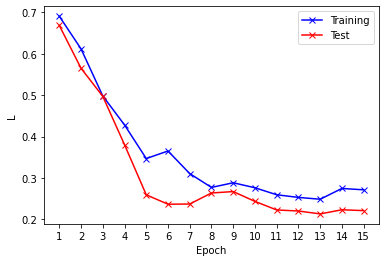

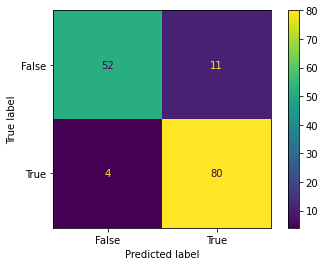

In [20]:
plot_losses_per_epoch(losses)
plot_confusion_matrix(losses)

Using 80% of the real MRI scnas as the training set and 20% of the real scans as the test set produce ≈ **90%** accuracy for 15 epochs

**Case 2:**


Train dataset: 100% Synthetic MRI Scans generated using WGAN GP

Test dataset: 100% Real MRI Scans

Epoch: 1, train loss: 0.68961, test loss: 0.63289, test accuracy: 0.58549, f1 score: 0.25503
Epoch: 2, train loss: 0.65338, test loss: 0.57059, test accuracy: 0.85853, f1 score: 0.87681
Epoch: 3, train loss: 0.53311, test loss: 0.45079, test accuracy: 0.81661, f1 score: 0.80543
Epoch: 4, train loss: 0.40399, test loss: 0.35626, test accuracy: 0.85836, f1 score: 0.82969
Epoch: 5, train loss: 0.28491, test loss: 0.40898, test accuracy: 0.86192, f1 score: 0.88800
Epoch: 6, train loss: 0.34661, test loss: 0.31892, test accuracy: 0.88284, f1 score: 0.89189
Epoch: 7, train loss: 0.27141, test loss: 0.27680, test accuracy: 0.89854, f1 score: 0.87273
Epoch: 8, train loss: 0.24162, test loss: 0.31796, test accuracy: 0.87016, f1 score: 0.84337
Epoch: 9, train loss: 0.25662, test loss: 0.26619, test accuracy: 0.89750, f1 score: 0.89057
Epoch: 10, train loss: 0.22885, test loss: 0.26811, test accuracy: 0.88691, f1 score: 0.91051
Epoch: 11, train loss: 0.22643, test loss: 0.25653, test accuracy: 0.

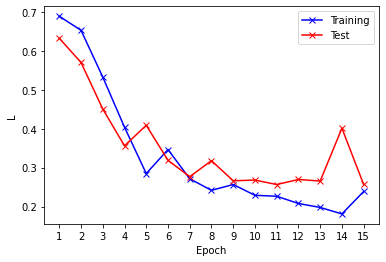

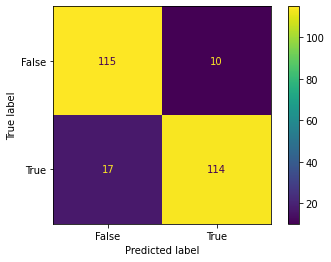

In [22]:
train_data = DataLoader(data_fake, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(data_real, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)
plot_confusion_matrix(losses)

Using 100% of the synthetic MRI scnas as the training set and 100% of the real scans produce ≈ **90%** accuracy for 15 epochs. 

Accuracy was ≈ 89.8% in the first case where we used only real data to train the model. In this case where we are training on synthetic data only, the accuracy is ≈ 90.1%.
This proves that synthetic data is able to train models with comparable performance to models trained on real data.

**Case 3:**

Train dataset: 50% Real MRI Scans + 50% synthetic MRI Scans generated using WGAN GP

Test dataset: 50% Real MRI Scans

Epoch: 1, train loss: 0.69534, test loss: 0.65541, test accuracy: 0.51002, f1 score: 0.00000
Epoch: 2, train loss: 0.66334, test loss: 0.67567, test accuracy: 0.58253, f1 score: 0.70588
Epoch: 3, train loss: 0.63743, test loss: 0.55780, test accuracy: 0.58122, f1 score: 0.20408
Epoch: 4, train loss: 0.55750, test loss: 0.50925, test accuracy: 0.93491, f1 score: 0.91667
Epoch: 5, train loss: 0.48709, test loss: 0.32784, test accuracy: 0.90692, f1 score: 0.88372
Epoch: 6, train loss: 0.33154, test loss: 0.23735, test accuracy: 0.90497, f1 score: 0.88496
Epoch: 7, train loss: 0.35235, test loss: 0.22544, test accuracy: 0.90549, f1 score: 0.87826
Epoch: 8, train loss: 0.34208, test loss: 0.23522, test accuracy: 0.91330, f1 score: 0.91241
Epoch: 9, train loss: 0.29683, test loss: 0.23216, test accuracy: 0.89951, f1 score: 0.90756
Epoch: 10, train loss: 0.28378, test loss: 0.24603, test accuracy: 0.91761, f1 score: 0.94071
Epoch: 11, train loss: 0.29007, test loss: 0.21453, test accuracy: 0.

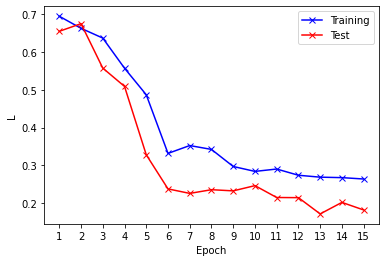

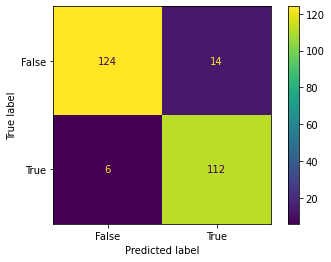

In [23]:
test_num = int(samples_num * 0.5) 
train_num = samples_num - test_num 

train_data_real, test_data_real = random_split(data_real, [train_num, test_num])
train_data_fake, _ = random_split(data_fake, [train_num, test_num])

train_data = train_data_real + train_data_fake

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data_real, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)
plot_confusion_matrix(losses)

Using 50% of the training sampels from the real MRI scans, and 50% come from the synthetic images. The test set comes from the other 50% of the real scans. The model produced ≈ **95%** accuracy, which is considerably higher than the performance of the model when using 80% of the real images as training data (accuracy was ≈ 90%). This proves that synthetic data can be added to the training samples when there is a lack of real data to help build more robust models.

# **Brain MRI Classification on DCGAN synthetic data**

In [25]:
from zipfile import ZipFile as zipfile
file_name = 'dcgan.zip'

with zipfile(file_name, 'r') as zip_file:
  zip_file.extractall()

In [30]:
data_real = os.path.abspath(os.getcwd()) + "/dcgan/real"
data_fake = os.path.abspath(os.getcwd()) + "/dcgan/fake"

img_size = 64

data_real = ImageFolder(data_real,transform = transforms.Compose([ transforms.Resize((img_size,img_size)),transforms.ToTensor()]))

data_fake = ImageFolder(data_fake, transform = transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()]))

**Case 4:**

Train dataset: 100% Synthetic MRI Scans generated using DCGAN

Test dataset: 100% Real MRI Scans

Epoch: 1, train loss: 0.69118, test loss: 0.65215, test accuracy: 0.54261, f1 score: 0.18919
Epoch: 2, train loss: 0.59484, test loss: 0.57788, test accuracy: 0.81843, f1 score: 0.86817
Epoch: 3, train loss: 0.49151, test loss: 0.45653, test accuracy: 0.83180, f1 score: 0.81423
Epoch: 4, train loss: 0.40938, test loss: 0.28818, test accuracy: 0.88535, f1 score: 0.86400
Epoch: 5, train loss: 0.35716, test loss: 0.45785, test accuracy: 0.82816, f1 score: 0.83333
Epoch: 6, train loss: 0.34735, test loss: 0.31637, test accuracy: 0.87824, f1 score: 0.87407
Epoch: 7, train loss: 0.32177, test loss: 0.27721, test accuracy: 0.89004, f1 score: 0.91791
Epoch: 8, train loss: 0.29930, test loss: 0.29265, test accuracy: 0.87667, f1 score: 0.88983
Epoch: 9, train loss: 0.26420, test loss: 0.29413, test accuracy: 0.88874, f1 score: 0.88561
Epoch: 10, train loss: 0.25689, test loss: 0.28978, test accuracy: 0.87945, f1 score: 0.85106
Epoch: 11, train loss: 0.25096, test loss: 0.25659, test accuracy: 0.

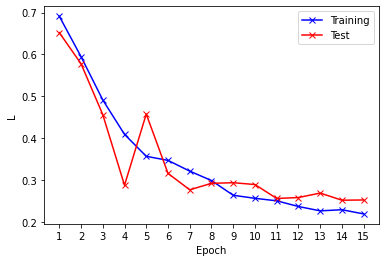

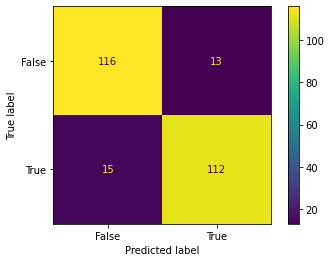

In [31]:
train_data = DataLoader(data_fake, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(data_real, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)
plot_confusion_matrix(losses)

Using 100% of the synthetic data generated by DCGAN as the training set and 100% of the real scans as the test set produce **≈ 90%** accuracy for 15 epochs. The network had a close performance to the model that was trained on real data only(case 1).




**Case 5:**

Train dataset: 80% Real MRI Scans + 100% synthetic MRI Scans generated using WGAN GP

Test dataset: 20% Real MRI Scans

Epoch: 1, train loss: 0.63490, test loss: 0.49145, test accuracy: 0.85034, f1 score: 0.85333
Epoch: 2, train loss: 0.47773, test loss: 0.27087, test accuracy: 0.91156, f1 score: 0.89256
Epoch: 3, train loss: 0.33934, test loss: 0.23406, test accuracy: 0.89796, f1 score: 0.88000
Epoch: 4, train loss: 0.27989, test loss: 0.21182, test accuracy: 0.89796, f1 score: 0.88550
Epoch: 5, train loss: 0.28579, test loss: 0.21854, test accuracy: 0.89796, f1 score: 0.88889
Epoch: 6, train loss: 0.26655, test loss: 0.21923, test accuracy: 0.89796, f1 score: 0.88722
Epoch: 7, train loss: 0.25033, test loss: 0.24427, test accuracy: 0.88435, f1 score: 0.88112
Epoch: 8, train loss: 0.25249, test loss: 0.21244, test accuracy: 0.91156, f1 score: 0.90370
Epoch: 9, train loss: 0.25921, test loss: 0.22177, test accuracy: 0.89116, f1 score: 0.88571
Epoch: 10, train loss: 0.24001, test loss: 0.25904, test accuracy: 0.90476, f1 score: 0.88525
Epoch: 11, train loss: 0.26854, test loss: 0.20849, test accuracy: 0.

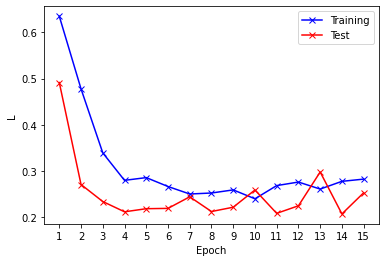

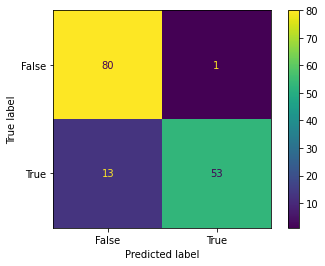

In [33]:
test_num = int(samples_num * 0.2) 
train_num = samples_num - test_num 

train_data, test_data = random_split(data_real, [train_num, test_num])
train_data += data_fake

train_data = DataLoader(train_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
test_data = DataLoader(test_data, batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)

model = ClassificationModel()

losses = fit(num_epochs, lr, model, train_data, test_data, opt_func)

plot_losses_per_epoch(losses)
plot_confusion_matrix(losses)

Using 80% of the real MRI scnas + 100% of the synthetic data as the training set and 20% of the real scans as the test set produce ≈ 92% accuracy for 14 epochs. This accuracy is higher than the model's accuracy that was trained on 80% of the real data only (accuracy was ≈ 90%). 

**Conclusion:**
All cases show an increased performance of the model over the test set when synethetic images were added to the training set.

Specifically, Case 3 and Case 5 prove that synthetic data can be used in the training dataset when there is a lack of real data or privacy concerns to help training more robust models.